In [7]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Keras neural network model
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import to_categorical, plot_model
from keras import optimizers, regularizers, initializers
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Dropout, BatchNormalization

# Scikit-sklearn preprocessing modules
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,\
                            classification_report, recall_score

# Matplotlib and plotly modules
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker

In [8]:
# latex parameter
font = {
    'family': 'serif', 
    'serif': ['Computer Modern Roman'],
    'weight' : 'regular',
    'size'   : 14
    }

plt.rc('font', **font)
plt.rc('text', usetex=True)

In [9]:
df_total = pd.read_csv("data/total_300.csv")

In [10]:
df_total.columns

Index(['velocity:0', 'velocity:1', 'force:0', 'force:1',
       'total displacement:0', 'total displacement:1', 'temperature',
       'temp_power', 'temp_pressure', 'temp_density', 'node number',
       'plastic strain', 'plastic strain-rate', 'strain-rate II log10',
       'strain-rate XX', 'elastic_strain XX', 'strain-rate ZZ',
       'elastic_strain ZZ', 'strain-rate XZ', 'elastic_strain XZ', 'strain I',
       'strain II', 'strain XX', 'strain ZZ', 'strain XZ', 'stress I',
       'stress II', 'stress XX', 'stress ZZ', 'stress XZ', 'density',
       'thermal_stress', 'energy_total_vol_dev', 'energy_volumetric',
       'energy_deviatoric', 'energy_thermal', 'energy_elastic', 'coordinate:0',
       'coordinate:1'],
      dtype='object')

In [11]:
df_total = df_total.drop_duplicates()

## Plastic strain distribution

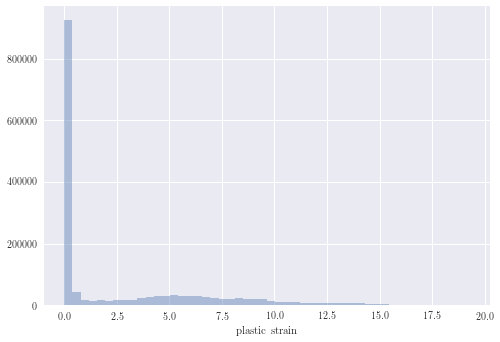

In [12]:
sns.distplot(df_total['plastic strain'], kde=False)
plt.show()

In [13]:
threshold = 0.15
df_total['plastic strain'] = np.where(df_total['plastic strain'] > threshold, 1,0)

In [14]:
label_count = df_total.groupby(df_total['plastic strain'], as_index = False).count()

In [15]:
label_count.head()

,velocity:0,velocity:1,force:0,force:1,total displacement:0,total displacement:1,temperature,temp_power,temp_pressure,temp_density,...,stress XZ,density,thermal_stress,energy_total_vol_dev,energy_volumetric,energy_deviatoric,energy_thermal,energy_elastic,coordinate:0,coordinate:1
0,824099,824099,824099,824099,824099,824099,824099,824099,824099,824099,...,824099,824099,824099,824099,824099,824099,824099,824099,824099,824099
1,784160,784160,784160,784160,784160,784160,784160,784160,784160,784160,...,784160,784160,784160,784160,784160,784160,784160,784160,784160,784160


In [16]:
class_name = list(label_count['plastic strain'])
count = list(label_count['velocity:0'])

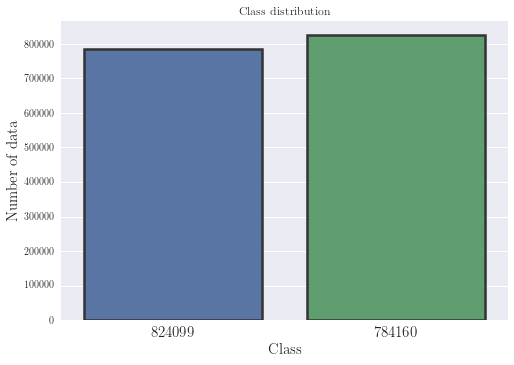

In [17]:
index = np.arange(len(class_name))
# plt.bar(class_name, count)
sns.barplot(x=class_name, y=count, linewidth=2.5, errcolor=".2", edgecolor=".2")
plt.xlabel('Class', fontsize=15)
plt.ylabel('Number of data', fontsize=15)
plt.xticks(index, class_name, fontsize=15)
plt.title('Class distribution')
plt.show()

In [18]:
feature_cols = ['velocity:0', 'velocity:1', 'temperature', 'coordinate:1', 'density']

dropped_cols = ['plastic strain', 'plastic strain-rate', 'strain-rate II log10', 'strain-rate XX',
       'elastic_strain XX', 'strain-rate ZZ', 'elastic_strain ZZ',
       'strain-rate XZ', 'elastic_strain XZ', 'strain I', 'strain II',
       'strain XX', 'strain ZZ', 'strain XZ', 'coordinate:0', 'coordinate:1', 'force:0', 'force:1', 
       'total displacement:0', 'total displacement:1', 'stress I', 'stress II', 'energy_volumetric', 
       'energy_deviatoric','energy_thermal', 'energy_elastic', 'thermal_stress',
       'energy_total_vol_dev', 'temp_power', 'temp_pressure', 'temp_density', 'node number']

## Pairplot

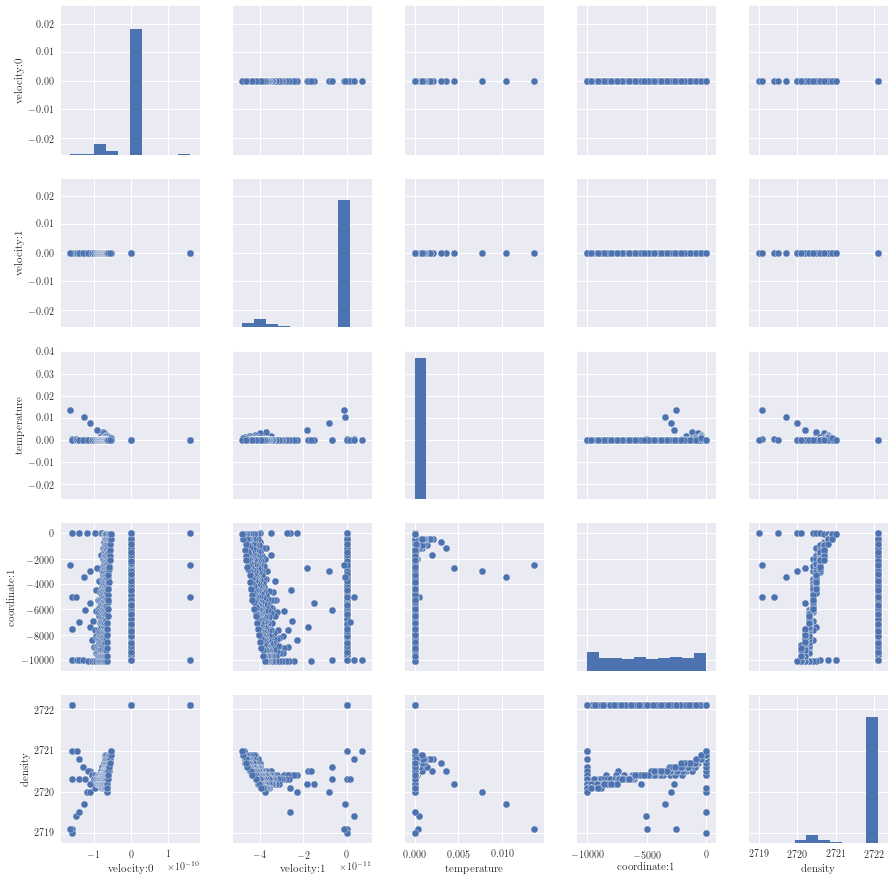

In [311]:
sns.pairplot(df_total[feature_cols][0:3000])
plt.show()

In [352]:
df_total[feature_cols].describe()

,velocity:0,velocity:1,temperature,coordinate:1,density
count,1.608259e+06,1.608259e+06,1.608259e+06,1.608259e+06,1.608259e+06
mean,5.441602e-11,4.554219e-11,4.891623e+00,-2.927265e+03,2.448042e+03
std,1.480671e-10,8.558062e-11,7.247687e+00,3.757562e+03,3.469190e+02
min,-1.622500e-09,-5.188100e-10,-1.694000e-07,-1.010000e+04,1.181700e+03
25%,-8.711300e-11,-2.544350e-12,2.052800e-01,-5.832750e+03,2.300800e+03
50%,1.108600e-10,6.946700e-12,1.032800e+00,-2.601700e+03,2.589800e+03
75%,1.646600e-10,8.511050e-11,6.911650e+00,1.250850e+02,2.717000e+03
max,1.175000e-09,9.874200e-10,4.420500e+01,4.063900e+03,2.726500e+03


### Scaling features

In [19]:
def scale_feature(features):    
    mms = StandardScaler()
    scaled_features = mms.fit_transform(features)
    return scaled_features, mms

## Neural network model

In [20]:
class build_neural_network:
    
    def __init__(self, model_name, xtrain, ytrain, xval, yval):
        self.model_name = model_name
        self.xtrain = xtrain
        self.ytrain = to_categorical(ytrain)
        self.xval = xval
        self.yval = to_categorical(yval)
        self.input_shape = np.shape(xtrain)[1]
        self.output_shape = np.shape(self.ytrain)[1]
        self.model = None
        self.ypred = None
        self.weight_path = "./weights/"
            
    def get_model_weights(self):
        return self.model.get_weights()

    def create_model(self):
        self.model = Sequential()
        self.model.add(Dense(self.input_shape, 
                             kernel_initializer = initializers.RandomNormal(mean=0.0, stddev=0.05, seed = 2018), 
                             activation = 'relu', name='layer_1',
                             input_shape = (self.input_shape,)))
        
        self.model.add(Dense(12, activation = 'relu', name='layer_2'))
            
        self.model.add(Dense(self.output_shape, activation="softmax", name='Output_layer'))
        self.model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
        self.model.summary()
        
    
    def train_model(self, training_epochs):
        self.create_model()
        
        filepath = self.weight_path + str(self.model_name) + '.hdf5'
        
        if not os.path.exists(self.weight_path):
            os.makedirs(self.weight_path)
        
        checkpoint = ModelCheckpoint(filepath, verbose=0, period = training_epochs)
        
        self.model.fit(self.xtrain, self.ytrain, batch_size = 64, epochs = training_epochs, 
        callbacks = [checkpoint], validation_data=(self.xval, self.yval))
        
        self.save_model()
        
    def save_model(self):
        file_name = str(self.weight_path) + str(self.model_name)
        self.model.save(file_name)
    
    def predict(self, xtest):
        self.ypred = self.model.predict(xtest)


In [63]:
Y = df_total['plastic strain']
X, mms = scale_feature(df_total[feature_cols])
xtrain, xval, ytrain, yval = train_test_split(X, Y, test_size=0.50, random_state=2018, shuffle=True)

In [ ]:
model_name = "Total"
model = build_neural_network(model_name, xtrain, ytrain, xval, yval)
model.train_model(10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
layer_2 (Dense)              (None, 12)                72        
_________________________________________________________________
Output_layer (Dense)         (None, 2)                 26        
Total params: 128
Trainable params: 128
Non-trainable params: 0
_________________________________________________________________
Train on 804129 samples, validate on 804130 samples
Epoch 1/10
804129/804129 [==============================] - 48s - loss: 0.0653 - acc: 0.9786 - val_loss: 0.0480 - val_acc: 0.9833
Epoch 2/10
804129/804129 [==============================] - 49s - loss: 0.0457 - acc: 0.9839 - val_loss: 0.0436 - val_acc: 0.9844
Epoch 3/10
804129/804129 [==============================] - 48s - loss: 0.0429 - acc: 0.9846 - v

In [23]:
history_keys = model.model.model.history.history.keys()
history = model.model.model.history.history

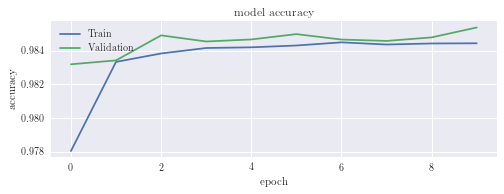

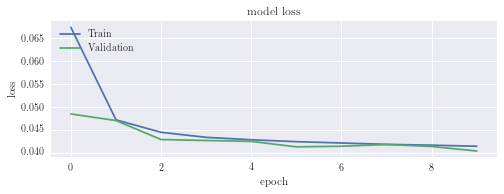

In [24]:
# summarize history for accuracy
plt.subplot(2,1,1)
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.subplot(2,1,2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [25]:
val = 400
file_name = "new_data/totoal."+ str(val) +".csv"
df_test = pd.read_csv(file_name)
df_test = df_test.drop_duplicates()
df_test['plastic strain'] = np.where(df_test['plastic strain'] > threshold, 1,0)
xtest = df_test[feature_cols]
ytest = df_test['plastic strain']
xtest = mms.fit_transform(xtest)

In [26]:
ypred = model.model.predict(xtest)

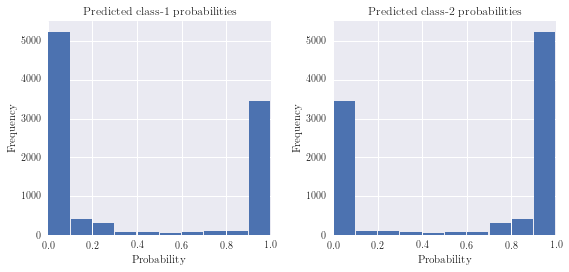

In [27]:
# histogram of predicted probabilities
plt.figure(figsize=(12, 4))
nclasses = 2
for i in range(nclasses):
    
    plt.subplot(1, 3, i+1)
    plt.hist(ypred[:, i], bins=10, histtype='bar', rwidth=0.95)
    plt.xlim(0,1)
    plt.title('Predicted class-{} probabilities'.format(i+1))
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [28]:
def repredict(ypred):
    length = (ypred.shape)[0]
    newpred = []
    for i in range(length):
        if ypred[i, 1] >= 0.6:
            newpred.append(1)
        else:
            newpred.append(0)
    return newpred

In [29]:
newpred_test = repredict(ypred)

In [50]:
def model_report(ytest, ypred):
    print('1. The F-1 score of the model {}\n'.format(f1_score(ytest, ypred, average='macro')))
    print('2. The recall score of the model {}\n'.format(recall_score(ytest, ypred, average='macro')))
    print('3. Classification report \n {} \n'.format(classification_report(ytest, ypred)))
    print('4. Confusion matrix \n {} \n'.format(confusion_matrix(ytest, ypred)))

In [51]:
model_report(ytest, newpred_test)

1. The F-1 score of the model 0.8846975545217799

2. The recall score of the model 0.9083024734683146

3. Classification report 
              precision    recall  f1-score   support

          0       0.77      0.95      0.85      3183
          1       0.97      0.87      0.92      6768

avg / total       0.91      0.89      0.90      9951
 

4. Confusion matrix 
 [[3015  168]
 [ 884 5884]] 



## Test data preparation

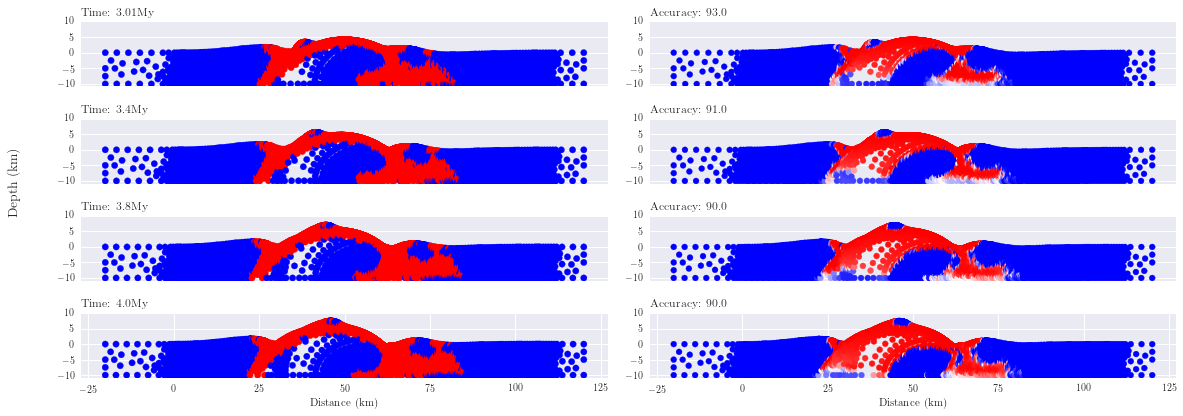

In [351]:
times = [301, 340, 380, 400]
fig = plt.figure(figsize = (16,6))

for i, val  in enumerate(times):
    
    file_name = "new_data/totoal."+ str(val) +".csv"
    df_test = pd.read_csv(file_name)
    df_test = df_test.drop_duplicates()
    df_test['plastic strain'] = np.where(df_test['plastic strain'] > threshold, 1,0)
    xtest = df_test[feature_cols]
    ytest = df_test['plastic strain']
    xtest = mms.fit_transform(xtest)
    ypred = model.model.predict(xtest)
    newpred_test = repredict(ypred)
    acc = accuracy_score(ytest, newpred_test)
    
    ## Plot figure
    plt.subplot(len(times), 2, (i+(i+1)))
    plt.scatter(x = df_test['coordinate:0']/1e3, y= df_test['coordinate:1']/1e3, 
                c = df_test['plastic strain'], vmin=0, vmax=1, s = 40 , cmap='bwr')
    plt.title('Time: ' + str(val/100.0)+'My', loc='left')
    plt.yticks([10, 5, 0, -5, -10])
    if (i+2) == 5:
        plt.xticks([-25, 0, 25, 50, 75, 100, 125])
        plt.xlabel('Distance (km)')
    else:
        plt.xticks([])
        
    
    plt.subplot(len(times), 2, (i+(i+2)))
    plt.scatter(df_test['coordinate:0']/1e3, y= df_test['coordinate:1']/1e3,\
                c = ypred[:, 1],\
                vmin = 0, vmax = 1, s = 35, cmap = 'bwr')
    
    plt.title('Accuracy: '+ str(round(acc, 2)*100) + '%', loc='left')
    plt.yticks([10, 5, 0, -5, -10])
    
    if (i+2) == 5:
        plt.xticks([-25, 0, 25, 50, 75, 100, 125])
        plt.xlabel('Distance (km)')
    else:
        plt.xticks([])
        
plt.text(-215, 60, 'Depth (km)', rotation=90)
plt.tight_layout()
fig.savefig('original_vs_predicted.png')
plt.show()

### Error ananlysis on validation data

In [49]:
valpred = model.model.predict(xval)

In [53]:
valpred = repredict(valpred)

In [54]:
model_report(yval, valpred)

1. The F-1 score of the model 0.9852076547755597

2. The recall score of the model 0.9852006383705452

3. Classification report 
              precision    recall  f1-score   support

          0       0.99      0.99      0.99    412358
          1       0.99      0.98      0.98    391772

avg / total       0.99      0.99      0.99    804130
 

4. Confusion matrix 
 [[406528   5830]
 [  6057 385715]] 



In [61]:
df_true_predictions = pd.DataFrame([], index=index, columns=feature_cols)
df_zero_as_one = pd.DataFrame([], index=index, columns=feature_cols)
df_one_as_zero = pd.DataFrame([], index=index, columns=feature_cols)

yval_new = list(yval)

for i in range(len(yval_new)):
    if valpred[i] == 0 and yval_new[i] == 1:
        df_zero_as_one.loc[i] = xval[i, :]
    elif valpred[i] == 1 and yval_new[i] == 0:
        df_one_as_zero.loc[i] = xval[i, :] 
    else:
        df_true_predictions.loc[i] = xval[i, :]

KeyboardInterrupt: 

In [48]:
df_true_predictions.describe()

,velocity:0,velocity:1,temperature,coordinate:1,density
count,8899.00000,8899.000000,8899.000000,8899.000000,8899.000000
unique,7837.00000,8523.000000,7953.000000,8377.000000,4816.000000
top,-2.46431,-0.370275,-0.601249,-1.769723,1.133488
freq,6.00000,8.000000,705.000000,279.000000,46.000000


In [46]:
df_zero_as_one.describe()

,velocity:0,velocity:1,temperature,coordinate:1,density
count,884.000000,884.000000,884.000000,884.000000,884.000000
mean,-0.120659,-0.453068,0.388646,-0.630923,0.472481
std,0.891040,0.696111,0.991738,1.091406,0.288040
min,-2.361332,-2.204269,-0.601249,-1.769723,-1.505225
25%,-0.878650,-1.095101,-0.402096,-1.717972,0.406353
50%,0.271114,-0.189432,-0.133893,-0.777986,0.516362
75%,0.339111,0.022875,1.167430,0.008070,0.652715
max,1.417112,2.611059,4.849467,1.796492,0.885186


In [47]:
df_one_as_zero.describe()

,velocity:0,velocity:1,temperature,coordinate:1,density
count,168.000000,168.000000,168.000000,168.000000,168.000000
mean,-0.186365,0.513572,1.254919,-0.764262,-0.912207
std,0.496337,1.267298,1.426541,0.824313,0.693056
min,-1.276328,-2.022846,-0.524240,-1.769723,-2.217342
25%,-0.647233,-0.178735,-0.052306,-1.690198,-1.387519
50%,0.011269,0.218238,0.710684,-0.847512,-1.116001
75%,0.217099,1.855816,2.705080,-0.008574,-0.141564
max,0.682979,2.592737,4.776314,0.880302,0.384576


## Add application to real world

In [ ]:
app_feature_cols = ['velocity:0', 'velocity:1', 'temperature', 'stress XX', 'stress ZZ', 'stress XZ', 'density']